In [1]:
!pip install opencv-python
!pip install opencv-python-headless

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
from keras.applications.vgg16 import VGG16 as vgg16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from math import floor
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from numpy import expand_dims, array, exp, max
import json
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.densenet import DenseNet169 as densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
import os
import scipy
from scipy import ndimage
import imageio
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
import random

In [3]:
# set the model hyper parameters
BATCH_SIZE = 8
# set the image size to fit the resnet model for lower overfitting
IMG_SIZE = (224, 224)

In [4]:
#@train_df = pd.read_csv("files/test_correlation_above_glcm.csv")
#train_df2 = pd.read_csv("files/test_correlation_below_glcm.csv")

train_df = pd.read_csv("files/stanford/lbp/stanford_lbp_above.csv")
train_df2 = pd.read_csv("files/stanford/lbp/stanford_lbp_below.csv")

In [5]:
print(train_df2)

                                              file                       label
0     n02108915-French_bulldog/n02108915_11550.jpg    n02108915-French_bulldog
1      n02108915-French_bulldog/n02108915_7608.jpg    n02108915-French_bulldog
2      n02108915-French_bulldog/n02108915_1788.jpg    n02108915-French_bulldog
3      n02108915-French_bulldog/n02108915_5337.jpg    n02108915-French_bulldog
4      n02108915-French_bulldog/n02108915_3153.jpg    n02108915-French_bulldog
..                                             ...                         ...
888  n02113712-miniature_poodle/n02113712_9013.jpg  n02113712-miniature_poodle
889  n02113712-miniature_poodle/n02113712_1805.jpg  n02113712-miniature_poodle
890  n02113712-miniature_poodle/n02113712_1088.jpg  n02113712-miniature_poodle
891  n02113712-miniature_poodle/n02113712_3049.jpg  n02113712-miniature_poodle
892  n02113712-miniature_poodle/n02113712_3261.jpg  n02113712-miniature_poodle

[893 rows x 2 columns]


In [6]:
train_dataset_gen = ImageDataGenerator(rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.15, 
        brightness_range=[0.7, 1.4],
        vertical_flip=True,  
        horizontal_flip=True,
        rotation_range=15, 
        
        
        width_shift_range=0.1, 
        height_shift_range=0.1,
        validation_split=0.2,
        fill_mode='nearest')

In [7]:
training_dataset = train_dataset_gen.flow_from_dataframe(dataframe=train_df,
                                                         directory="StanfordDogs/Stanford_Dogs/Images",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

training_dataset2 = train_dataset_gen.flow_from_dataframe(dataframe=train_df2,
                                                         directory="StanfordDogs/Stanford_Dogs/Images/",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

Found 540 non-validated image filenames belonging to 10 classes.
Found 715 non-validated image filenames belonging to 10 classes.


In [8]:
model_name = vgg16
input_t =(224, 224, 3)
#model = tf.keras.applications.DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_t)

model_t = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

model_t2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

In [9]:
model_t.trainable = False
model_t2.trainable = False

In [10]:
#finetune by removeing the last layer
#for layer in model_t.layers[:-2]:
    #layer.trainable = False

In [11]:
#model classifier topup
#reg=0.001

model = Sequential()
model.add(model_t)
model.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(10, activation='softmax'))


model2 = Sequential()
model2.add(model_t2)
model2.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(10, activation='softmax'))

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [13]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history = model.fit(training_dataset, batch_size=4, shuffle=True, epochs=150, verbose=1)

model2.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history2 = model2.fit(training_dataset2, batch_size=4, shuffle=True, epochs=150, verbose=1)


Epoch 1/150
68/68 [==============================] - 16s 187ms/step - loss: 2.6593 - accuracy: 0.1494 - precision: 0.2351 - recall: 0.0506
Epoch 2/150
68/68 [==============================] - 8s 122ms/step - loss: 2.2366 - accuracy: 0.3034 - precision: 0.3574 - recall: 0.1077
Epoch 3/150
68/68 [==============================] - 8s 122ms/step - loss: 1.9926 - accuracy: 0.3141 - precision: 0.4501 - recall: 0.1408
Epoch 4/150
68/68 [==============================] - 8s 123ms/step - loss: 1.8293 - accuracy: 0.3662 - precision: 0.5614 - recall: 0.1775
Epoch 5/150
68/68 [==============================] - 8s 124ms/step - loss: 1.6987 - accuracy: 0.4004 - precision: 0.6129 - recall: 0.2394
Epoch 6/150
68/68 [==============================] - 8s 123ms/step - loss: 1.7264 - accuracy: 0.4083 - precision: 0.5458 - recall: 0.2025
Epoch 7/150
68/68 [==============================] - 8s 123ms/step - loss: 1.5952 - accuracy: 0.4490 - precision: 0.5746 - recall: 0.2532
Epoch 8/150
68/68 [==============

Epoch 60/150
68/68 [==============================] - 8s 123ms/step - loss: 0.9133 - accuracy: 0.7077 - precision: 0.8650 - recall: 0.5242
Epoch 61/150
68/68 [==============================] - 8s 122ms/step - loss: 0.9175 - accuracy: 0.7357 - precision: 0.8441 - recall: 0.5360
Epoch 62/150
68/68 [==============================] - 8s 122ms/step - loss: 0.8421 - accuracy: 0.7641 - precision: 0.8897 - recall: 0.5996
Epoch 63/150
68/68 [==============================] - 8s 123ms/step - loss: 0.8697 - accuracy: 0.7064 - precision: 0.8506 - recall: 0.5377
Epoch 64/150
68/68 [==============================] - 8s 122ms/step - loss: 0.7865 - accuracy: 0.7442 - precision: 0.9104 - recall: 0.5854
Epoch 65/150
68/68 [==============================] - 8s 122ms/step - loss: 0.9573 - accuracy: 0.6840 - precision: 0.8118 - recall: 0.4819
Epoch 66/150
68/68 [==============================] - 8s 124ms/step - loss: 0.8939 - accuracy: 0.7012 - precision: 0.8263 - recall: 0.5208
Epoch 67/150
68/68 [=======

68/68 [==============================] - 8s 123ms/step - loss: 0.7524 - accuracy: 0.7682 - precision: 0.8730 - recall: 0.5994
Epoch 119/150
68/68 [==============================] - 8s 122ms/step - loss: 0.8216 - accuracy: 0.7522 - precision: 0.8373 - recall: 0.5593
Epoch 120/150
68/68 [==============================] - 8s 123ms/step - loss: 0.8097 - accuracy: 0.7515 - precision: 0.8782 - recall: 0.5779
Epoch 121/150
68/68 [==============================] - 8s 123ms/step - loss: 0.7513 - accuracy: 0.7724 - precision: 0.8719 - recall: 0.5815
Epoch 122/150
68/68 [==============================] - 8s 124ms/step - loss: 0.8127 - accuracy: 0.7483 - precision: 0.8649 - recall: 0.5543
Epoch 123/150
68/68 [==============================] - 8s 124ms/step - loss: 0.7496 - accuracy: 0.7847 - precision: 0.8853 - recall: 0.5975
Epoch 124/150
68/68 [==============================] - 8s 122ms/step - loss: 0.7702 - accuracy: 0.7756 - precision: 0.8874 - recall: 0.5718
Epoch 125/150
68/68 [=============

90/90 [==============================] - 11s 122ms/step - loss: 0.9960 - accuracy: 0.6811 - precision: 0.8163 - recall: 0.4853
Epoch 27/150
90/90 [==============================] - 11s 121ms/step - loss: 1.0174 - accuracy: 0.6577 - precision: 0.7959 - recall: 0.4861
Epoch 28/150
90/90 [==============================] - 11s 121ms/step - loss: 0.9551 - accuracy: 0.6948 - precision: 0.8364 - recall: 0.4816
Epoch 29/150
90/90 [==============================] - 11s 122ms/step - loss: 1.0154 - accuracy: 0.6678 - precision: 0.7951 - recall: 0.4886
Epoch 30/150
90/90 [==============================] - 11s 122ms/step - loss: 1.0042 - accuracy: 0.6973 - precision: 0.8158 - recall: 0.5224
Epoch 31/150
90/90 [==============================] - 11s 120ms/step - loss: 0.9963 - accuracy: 0.6811 - precision: 0.8049 - recall: 0.4860
Epoch 32/150
90/90 [==============================] - 11s 122ms/step - loss: 1.0416 - accuracy: 0.6280 - precision: 0.7748 - recall: 0.4417
Epoch 33/150
90/90 [=============

90/90 [==============================] - 11s 121ms/step - loss: 0.9015 - accuracy: 0.7050 - precision: 0.8505 - recall: 0.5303
Epoch 85/150
90/90 [==============================] - 11s 122ms/step - loss: 0.9275 - accuracy: 0.6873 - precision: 0.8000 - recall: 0.4973
Epoch 86/150
90/90 [==============================] - 11s 121ms/step - loss: 0.8991 - accuracy: 0.7226 - precision: 0.8288 - recall: 0.5274
Epoch 87/150
90/90 [==============================] - 11s 122ms/step - loss: 0.9175 - accuracy: 0.6982 - precision: 0.8474 - recall: 0.5024
Epoch 88/150
90/90 [==============================] - 11s 120ms/step - loss: 0.9322 - accuracy: 0.6957 - precision: 0.8296 - recall: 0.4980
Epoch 89/150
90/90 [==============================] - 11s 120ms/step - loss: 0.8485 - accuracy: 0.7177 - precision: 0.8345 - recall: 0.5568
Epoch 90/150
90/90 [==============================] - 11s 122ms/step - loss: 0.8677 - accuracy: 0.7200 - precision: 0.8324 - recall: 0.5230
Epoch 91/150
90/90 [=============

90/90 [==============================] - 11s 122ms/step - loss: 0.8418 - accuracy: 0.7298 - precision: 0.8548 - recall: 0.5576
Epoch 148/150
90/90 [==============================] - 11s 121ms/step - loss: 0.8027 - accuracy: 0.7221 - precision: 0.8569 - recall: 0.5653
Epoch 149/150
90/90 [==============================] - 11s 122ms/step - loss: 0.8006 - accuracy: 0.7271 - precision: 0.8473 - recall: 0.6026
Epoch 150/150
90/90 [==============================] - 11s 122ms/step - loss: 0.7150 - accuracy: 0.7774 - precision: 0.8806 - recall: 0.6331


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


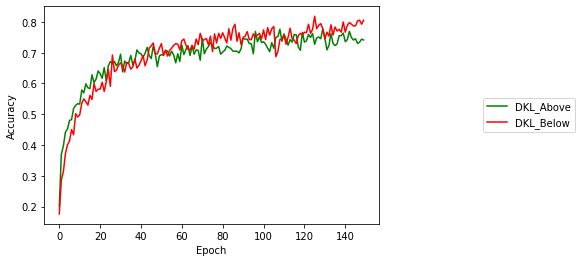

In [22]:
fig1 = plt.figure()

plt.plot(history2.history['accuracy'], color='g')
plt.plot(history.history['accuracy'], color='r')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('vgg16_lbp_DKL_accuracy_stanford.eps',  dpi=1000, format="eps", bbox_inches="tight") 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


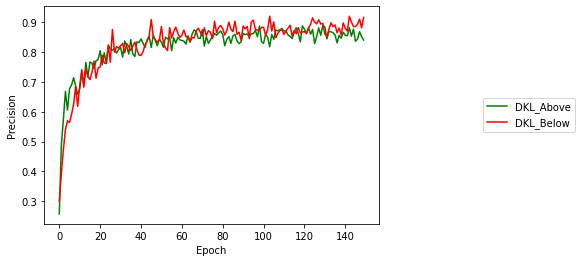

In [21]:
fig1 = plt.figure()
plt.plot(history2.history['precision'], color='g')
plt.plot(history.history['precision'], color='r')

plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('vgg16_lbp_DKL_precision_stanford.eps',  dpi=1000, format="eps", bbox_inches="tight") 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


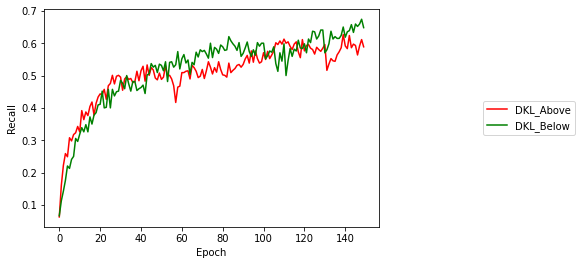

In [20]:
fig1 = plt.figure()
plt.plot(history2.history['recall'], color='r')
plt.plot(history.history['recall'], color='g')

plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('vgg16_lbp_DKL_recall_stanford.eps',  dpi=1000, format="eps", bbox_inches="tight") 
